# wine reviews


## 1.数据可视化和摘要


本数据集是对葡萄酒的点评。

Name：wine-data_first150k

In [52]:
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression


df = pd.read_csv('winemag-data_first150k.csv', index_col=0)
df.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude



### 1.1 数据摘要


- 标称属性和数值属性


In [53]:
numeric_fields = df.select_dtypes(include=np.number).columns.values
nominal_fields = df.select_dtypes(exclude=np.number).columns.values
print('Numeric fields:', numeric_fields)
print('Nominal fields:', nominal_fields)

Numeric fields: ['points' 'price']
Nominal fields: ['country' 'description' 'designation' 'province' 'region_1' 'region_2'
 'variety' 'winery']



标称属性，给出每个可能聚会的频数


In [54]:
for name in nominal_fields:
    print(df.groupby(name).size())

country
Albania                       2
Argentina                  5631
Australia                  4957
Austria                    3057
Bosnia and Herzegovina        4
Brazil                       25
Bulgaria                     77
Canada                      196
Chile                      5816
China                         3
Croatia                      89
Cyprus                       31
Czech Republic                6
Egypt                         3
England                       9
France                    21098
Georgia                      43
Germany                    2452
Greece                      884
Hungary                     231
India                         8
Israel                      630
Italy                     23478
Japan                         2
Lebanon                      37
Lithuania                     8
Luxembourg                    9
Macedonia                    16
Mexico                       63
Moldova                      71
Montenegro                    2



数值属性，给出5数概括及缺失值的个数


In [55]:
describe = df.describe()
total = len(df)
data = {}
for field in describe.columns:
    data[field] = total - describe[field]['count']

describe = describe.append(pd.Series(data, name='miss'))
describe

,points,price
count,150930.000000,137235.000000
mean,87.888418,33.131482
std,3.222392,36.322536
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,24.000000
75%,90.000000,40.000000
max,100.000000,2300.000000
miss,0.000000,13695.000000



### 1.2 数据的可视化


- 针对数值属性: 绘制直方图，用qq图检验其分布是否为正态分布。



points属性符合正态分布。


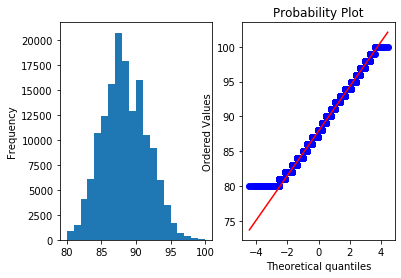

In [56]:
def hist_and_qqplot(series): 
    plt.subplot(1, 2, 1)
    series.plot.hist(bins=20)
    plt.subplot(1, 2, 2)
    stats.probplot(series, dist="norm", plot=pylab)
    
hist_and_qqplot(df['points'])


price属性不符合正态分布。


C:\Users\yjn\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yjn\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yjn\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


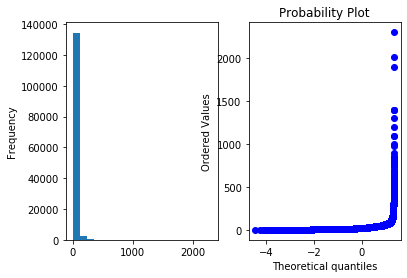

In [57]:
hist_and_qqplot(df['price'])


- 针对数值属性: 绘制盒图，对离群值进行识别


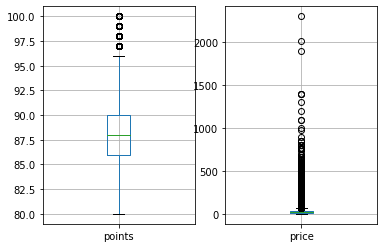

In [58]:
plt.subplot(1, 2, 1)
df.boxplot('points')
plt.subplot(1, 2, 2)
df.boxplot('price')


## 2. 数据缺失的处理


### 2.1 缺失数据原因分析

观察数据集中缺失数据，分析其缺失的原因。

country, designation, province, region_1, region_2等地址信息的缺失可能是由于信息内容的复杂程度限制了品酒人对信息的填写；

price价格的缺失可能是由于对于价格不够关注或者价格缺少等原因；

taster_name, taster_twitter_handle等品酒人信息的缺失可能是出于信息保护的匿名评价或者。


分别使用下列四种策略对缺失值进行处理:



- 将缺失部分剔除


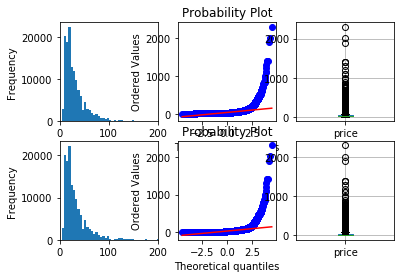

In [59]:
new_df = df.dropna(subset=['price'])


def plot_contract(dataframe, row):
    plt.subplot(2, 3, 1+3*row)
    new_df['price'].plot.hist(bins=500, xlim=(0, 200))
    plt.subplot(2, 3, 2+3*row)
    stats.probplot(new_df['price'], dist="norm", plot=pylab)
    plt.subplot(2, 3, 3+3*row)
    df.boxplot('price')


plot_contract(df, 0)
plot_contract(new_df, 1)


- 用最高频率值来填补缺失值


20.0


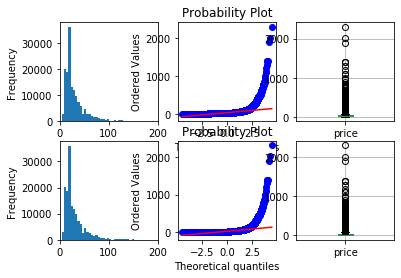

In [60]:
mode = df.mode()['price'][0]
new_df = df.fillna({'price': mode})
print(mode)

plot_contract(df, 0)
plot_contract(new_df, 1)


- 通过属性的相关关系来填补缺失值

利用价格和评分的正相关关系建立线性回归模型，通过评分来预测价格。


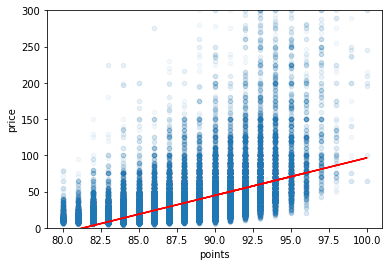

In [61]:
new_df = df.dropna(subset=['price'])
new_df.plot(kind="scatter", x="points", y="price", alpha=0.05)
x = new_df['points']
y = new_df['price']

from sklearn.linear_model import LinearRegression

X = np.array(x).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
plt.plot(X, model.predict(X), 'r-')
plt.ylim(0,300)
plt.show()

C:\Users\yjn\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yjn\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yjn\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\yjn\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yjn\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yjn\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


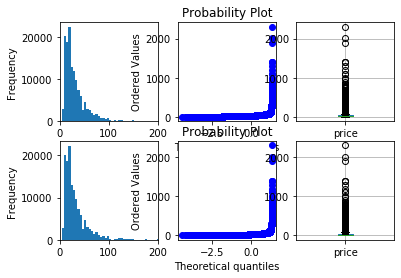

In [62]:
new_df = df.copy()
for index, row in new_df[df['price'].isna()].iterrows():
    row['price'] = model.predict(np.array(row['points']).reshape(-1, 1))

plot_contract(df, 0)
plot_contract(new_df, 1) 